# **Model Evaluation**

## Objectives

* Evaluate the performance of the optimized Gradient Boosting model.
* Analyze feature importance to understand which variables have the most influence on house prices.
* Ensure that the model meets the business requirement (R2 ≥ 0.75)

## Inputs

* The prepared dataset (`HousePricesFeatures.csv`)
* Libraries for machine learning and data handling, including:
  - **pandas** for data manipulation.
  - **sklearn** for machine learning and model training.
  - **matplotlib** and **seaborn** for visualizations.
  - **joblib** for saving and loading models.


## Outputs

* The optimized Gradient Boosting model is saved as: outputs/best_model/best_gradient_boosting_model.pkl.
* Visualization of feature importance.
* Model evaluation metrics (MSE, R2).
* Conclusions regarding the model's performance and usability.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

### Imports

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from xgboost import XGBRegressor

# Load data

In [2]:
df = pd.read_csv("outputs/datasets/collection/HousePricesFeatures.csv")
df.head()

,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,GarageArea,GrLivArea,OverallQual,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,...,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,SalePrice
0,1.213595,0.153895,0.575425,0.351000,0.370333,0.651479,0,0,0,1,...,0,0,0,1,0,0,0,1,0,208500.0
1,-0.756746,0.153895,1.171992,-0.060731,-0.482512,-0.071836,0,1,0,0,...,0,0,0,1,0,0,0,0,1,181500.0
2,1.241281,0.153895,0.092907,0.631726,0.515013,0.651479,0,0,1,0,...,0,0,0,1,0,0,0,1,0,223500.0
3,-0.756746,0.153895,-0.499274,0.790804,0.383659,0.651479,0,0,0,1,...,0,0,0,0,1,0,0,1,0,140000.0
4,-0.756746,1.416182,0.463568,1.698485,1.299326,1.374795,1,0,0,0,...,0,0,0,1,0,0,0,1,0,250000.0


In [3]:
# Define features and target variable
X = df.drop('SalePrice', axis=1)
y = np.log1p(df['SalePrice'])  # Log-transform the target variable

In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### **Gradient Boosting Regressor optimization**

In [14]:
pipeline = Pipeline([
    ('model', GradientBoostingRegressor(random_state=42))  # Model to train
])

# Define the parameters for randomized search
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Perform randomized search for hyperparameters
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid, n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found and evaluate the model
print(f"Best hyperparameters from random search: {random_search.best_params_}")

# Evaluate the optimized model
optimized_model = random_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test)

# Inverse log-transform predictions and target
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_optimized)

# Calculate metrics
mse_optimized = mean_squared_error(y_test_original, y_pred_original)
r2_optimized = r2_score(y_test_original, y_pred_original)

print(f"Optimized MSE: {mse_optimized}")
print(f"Optimized R2 Score: {r2_optimized}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   7.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   6.6s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   7.5s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   7.6s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   9.6s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=  10.8s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=  10.1s
[CV] END model__max_d

##### **XGBRegressor optimization**

In [13]:
pipeline = Pipeline([
    ('model', XGBRegressor(random_state=42))  # Model to train
])

# Define the parameters for randomized search
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__learning_rate': [0.01, 0.05, 0.1],  # Typical learning rates for XGBoost
    'model__subsample': [0.8, 1.0],  # Subsample ratio
    'model__colsample_bytree': [0.8, 1.0],  # Column subsample ratio
}


# Perform randomized search for hyperparameters
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid, n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found and evaluate the model
print(f"Best hyperparameters from random search: {random_search.best_params_}")

# Evaluate the optimized model
optimized_model = random_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test)

# Inverse log-transform predictions and target
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_optimized)

# Calculate metrics
mse_optimized = mean_squared_error(y_test_original, y_pred_original)
r2_optimized = r2_score(y_test_original, y_pred_original)

print(f"Optimized MSE: {mse_optimized}")
print(f"Optimized R2 Score: {r2_optimized}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.05, model__max_depth=None, model__n_estimators=100, model__subsample=1.0; total time=   1.8s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.05, model__max_depth=None, model__n_estimators=100, model__subsample=1.0; total time=   1.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=30, model__n_estimators=100, model__subsample=1.0; total time=   3.7s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=30, model__n_estimators=100, model__subsample=1.0; total time=   3.8s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=30, model__n_estimators=100, model__subsample=1.0; total time=   3.8s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=30, model__n_estimators=100, model__subsample=1.0; total time=   4.0s
[CV] END model__colsam

##### **Conclusion:**
Both models performed well, but **XGBRegressor** slightly outperforms **Gradient Boosting Regressor** with a higher R2 Score of **0.89** compared to **0.88** for **Gradient Boosting**. The **Mean Absolute Error** for both models is relatively similar, but **XGBRegressor** has a lower error.

Given this, **XGBRegressor** is chosen as the final model for predicting house prices due to its better performance after optimization.

In [16]:
# Save the best XGBRegressor model for reuse
joblib.dump(random_search.best_estimator_, 'outputs/best_model/best_xgboost_model.pkl')

['outputs/best_model/best_xgboost_model.pkl']

___

##### **Calculating Feature Importance**

In [17]:
# Calculate permutation importance
result = permutation_importance(optimized_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame to store the results
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Check the DataFrame
print(importance_df.head())

       Feature  Importance
5  OverallQual    0.441215
4    GrLivArea    0.241932
2   BsmtFinSF1    0.046593
3   GarageArea    0.034944
0     2ndFlrSF    0.019784


/tmp/ipykernel_3809/3389775739.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis", orient="h")


             Feature  Importance
5        OverallQual    0.441215
4          GrLivArea    0.241932
2         BsmtFinSF1    0.046593
3         GarageArea    0.034944
0           2ndFlrSF    0.019784
18  GarageFinish_Unf    0.005132
22    KitchenQual_TA    0.004419
1       BedroomAbvGr    0.004038
21    KitchenQual_Gd    0.003613
19    KitchenQual_Ex    0.002436
10  BsmtFinType1_ALQ    0.002433
9    BsmtExposure_No    0.001538
16  GarageFinish_Fin    0.001268
7    BsmtExposure_Gd    0.000246
12  BsmtFinType1_GLQ    0.000122
17  GarageFinish_RFn    0.000074
11  BsmtFinType1_BLQ    0.000066
8    BsmtExposure_Mn   -0.000095
13  BsmtFinType1_LwQ   -0.000212
6    BsmtExposure_Av   -0.000298
15  BsmtFinType1_Unf   -0.000404
14  BsmtFinType1_Rec   -0.000472
20    KitchenQual_Fa   -0.000797


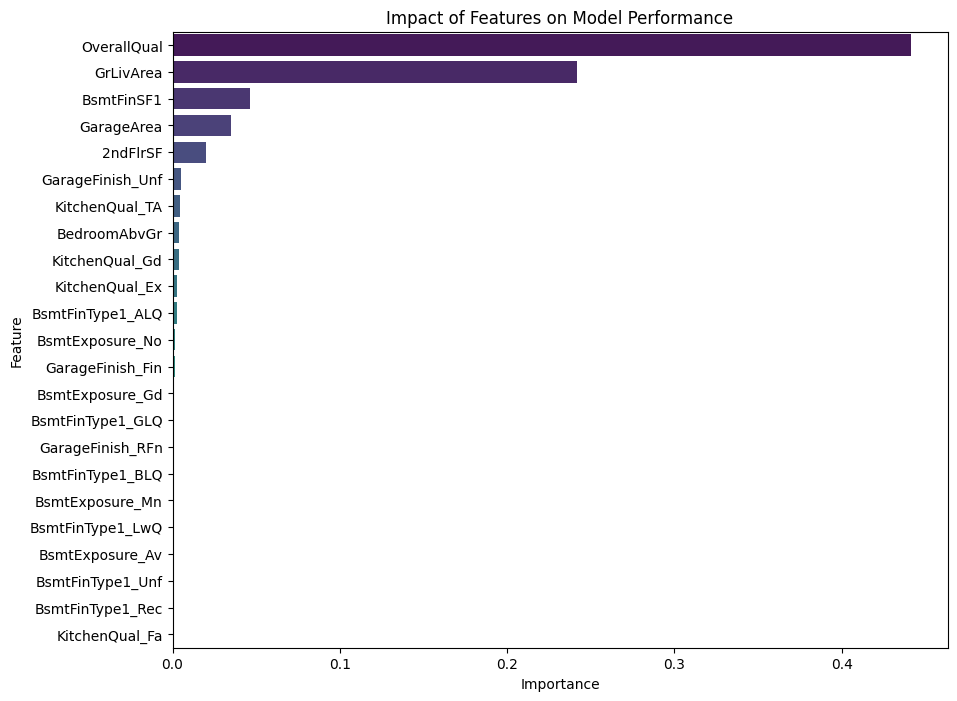

In [ ]:
# Visualize permutation importance
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis", orient="h")
plt.title("Impact of Features on Model Performance")
plt.xlabel("Importance")
plt.ylabel("Feature")

# Set the x-axis to start at 0
plt.xlim(left=0)

print(importance_df)

plt.show()

### Feature Importance Analysis
- The most important feature is **OverallQual**, which has the biggest impact on the model's performance.
- Other important features include **GrLivArea** and **BsmtFinSF1**, which also play significant roles.
- Features like **GarageArea** and **2ndFlrSF** have smaller impacts but still contribute to the predictions.
